# Tutorial 9: seq on the best 400 features, backword

---

### Introduction

Hello, this notebook will show how to use sqe to perform further feature selection, as we found that most features are very highly correlated, therfore we would need to remove those using the tool that we mentioned above. 

first, let us call the data

In [2]:
%store -r df_input_GS
%store -r y_GS
%store -r df_GS

In [3]:
y_GS = y_GS.map({'S': 1, 'B': 0})

---

calling some packages

In [4]:
# Python packages 
import pandas as pd # for importing data into data frame format
import seaborn as sns # For drawing useful graphs, such as bar graphs
import numpy as np
import matplotlib.pyplot as plt

---

<b><i> Data splitting </i></b> 

In [5]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, Ytrain, Ytest = train_test_split( df_input_GS, y_GS, test_size = 0.3, random_state=3, stratify=y_GS) # train and valid sets

In [6]:
print(Xtrain.shape)
print(Xtest.shape)

(352, 2074)
(151, 2074)


---

<b><i> get the best N features </i></b> 

In [7]:
%store -r featImp_GS

In [8]:
arrimp = np.array(featImp_GS).mean(0)
sorted_idx = arrimp.argsort()
print(sorted_idx[-10:])

[1793 1775 2048   31    3 1771  544 1781   17   45]


In [9]:
cols_ordered = df_input_GS.columns[sorted_idx][-100:]
cols_ordered

Index([2155.146, 2466.832,  956.341, 1906.353,  963.807,  1897.98, 1329.559,
        894.939, 1529.581, 1070.013, 2278.243, 1509.104,  855.375,  860.484,
        841.493, 1015.925,  958.462,  973.213, 2302.522,  875.005,  1011.17,
        897.418, 1427.665, 1502.109, 1021.932, 1892.438, 1000.633, 1454.089,
        865.367,  850.046,    860.2,  857.922,  900.848,  856.505, 1430.028,
        965.961,  876.188,  895.249, 1989.747,  864.501, 2457.479,  878.563,
        842.861, 1920.475,  847.268, 1923.324,  968.487,   858.49, 1909.161,
        846.162, 2280.247, 2011.358, 1437.162,  835.258,  851.721,  840.675,
        1956.71, 1142.636,  968.125,   841.22,  850.604, 1964.122, 1896.591,
        833.647,  836.066, 1917.633, 1924.752, 1903.554,  836.606, 1360.966,
       1953.761,  885.767, 1003.732,  983.551, 1913.388, 2043.058, 1946.427,
        985.046,  874.415,  986.545,   968.85,  844.508, 1959.668, 1926.182,
       1521.503,  836.875,  849.768,  984.672,  835.796,  842.587, 1968.596,

---

In [10]:
Xtrain[cols_ordered]

,2155.146,2466.832,956.341,1906.353,963.807,1897.980,1329.559,894.939,1529.581,1070.013,...,1968.596,1942.053,2441.281,842.040,834.451,1936.251,1010.382,1950.821,838.229,845.886
210,-0.249502,-0.129281,-0.798182,-0.064155,-0.790152,-0.104111,-0.632390,-0.828556,-0.360542,-0.806372,...,-0.103180,-0.064431,-0.126623,-0.852611,-0.868323,-0.056824,-0.791167,-0.077484,-0.863861,-0.859112
266,0.500780,0.379066,0.975850,0.285311,0.970638,0.308924,0.823537,1.040091,0.556191,1.022640,...,0.323973,0.292242,0.386553,1.040755,1.046849,0.284218,0.986368,0.303714,1.044837,1.048485
458,1.051702,0.903163,0.105490,0.961146,0.120742,0.994501,0.507108,-0.027778,1.041745,0.043741,...,0.992127,0.954164,0.948222,-0.020894,-0.012900,0.947342,0.135750,0.966534,-0.014697,-0.009475
322,0.809119,0.689823,1.082179,0.670888,1.076135,0.691781,0.949312,1.163621,0.842609,1.133553,...,0.693932,0.669354,0.738082,1.176984,1.173067,0.661299,1.091540,0.674564,1.178287,1.173193
171,-1.325722,-1.315748,-1.174019,-1.277710,-1.181853,-1.295564,-1.286257,-1.100079,-1.327750,-1.117588,...,-1.295124,-1.280268,-1.305844,-1.101613,-1.111279,-1.276586,-1.157541,-1.285318,-1.109319,-1.106318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,-0.434477,-0.219618,-0.666130,-0.258095,-0.652608,-0.311390,-0.549740,-0.760577,-0.560823,-0.723687,...,-0.318073,-0.258179,-0.249466,-0.775807,-0.771421,-0.246058,-0.683964,-0.277660,-0.772976,-0.771858
430,1.952713,1.804581,1.426319,1.946949,1.432421,1.983927,1.574301,1.393224,1.960317,1.398341,...,1.950348,1.916986,1.834398,1.378890,1.385954,1.913913,1.412999,1.927220,1.381970,1.384165
5,-0.557316,-0.442328,-0.950200,-0.388981,-0.953159,-0.387243,-0.898293,-0.930146,-0.671609,-0.954759,...,-0.417211,-0.403042,-0.442860,-0.919328,-0.912298,-0.401600,-0.971304,-0.407482,-0.916736,-0.915225
310,1.131692,1.124608,1.213821,1.084607,1.213873,1.078608,1.157921,1.248196,1.115707,1.238961,...,1.100754,1.096170,1.103933,1.246935,1.246373,1.096653,1.219850,1.098692,1.251592,1.253352


### SFS

In [12]:
# explore the number of selected features for RFE
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.pipeline import Pipeline
from matplotlib import pyplot
from sklearn.linear_model import LogisticRegression

In [13]:
# https://machinelearningmastery.com/rfe-feature-selection-in-python/
selected = []
imp_ind = []
imp_freq = []

for i in range(1, 51, 1):
    print(i)
    sfs = SequentialFeatureSelector(estimator=LogisticRegression(solver = 'newton-cg'), n_features_to_select=i, direction = 'backward')
    # fit sfs
    sfs.fit(Xtrain[cols_ordered].values, Ytrain)
    # summarize all features
    selected_feat = []
    for i in range(Xtrain[cols_ordered].shape[1]):
        if sfs.support_[i] == True:
            selected_feat.append(i)
            print('Column: %d, Selected %s,' % (i, sfs.support_[i]))
        
    # print()
    selected.append(selected_feat)
    
    result = list(set(imp_ind) ^ set(selected[-1]))
    imp_freq.extend(Xtrain[cols_ordered].columns[result])    
    imp_ind.extend(result)    
    
    print(selected[-1])
    print(result)
    print(imp_ind)
    print(imp_freq)
    print()
    
    

1


KeyboardInterrupt: 

---

In [ ]:
print(len(selected ))

print((selected ))
print(cols_ordered[-50:])
# selected.append(cols_ordered[-51:])
# selected.append(cols_ordered)

### LR

In [ ]:
lr = LogisticRegression()

In [ ]:
solvers = ['newton-cg', 'liblinear']
penalty = ['l2']
c_values = [1000, 100, 10, 1.0, 0.1, 0.01, 0.001]
lr_par = dict(solver=solvers,penalty=penalty,C=c_values)

In [ ]:
models = [[lr, 'lr', 14]]
par = [lr_par]

In [ ]:
from source.ml_acc import get_accuracy_ml

In [ ]:
num_ml_tools = len(par)
ml_dicts = {}

for m, par in zip(models, par):
    key0 = str(m[1])
    ml_dicts[key0] = {}
    for f in selected:
        print(cols_ordered[f])

        xtr =  Xtrain[cols_ordered].iloc[:, f]
        xte =  Xtest[cols_ordered].iloc[:, f]
        print(xtr)
        results = get_accuracy_ml (m[0], m[2], par, np.array(xtr), np.array(Ytrain), np.array(xte), np.array(Ytest)) # to get the accuracies for the ml model

        key = str(m[1])+","+str(len(f))
        ml_dicts[key0][key] = {}

        ml_dicts[key0][key]['tot_acc'] = results[0]
        ml_dicts[key0][key]['jack_train'] = results[1]
        ml_dicts[key0][key]['jack_test'] = results[2]

---

In [ ]:
import json

In [19]:
with open('ml_gs_fs999.txt', 'w') as file:
     file.write(json.dumps(ml_dicts)) # use `json.loads` to do the reverse

In [20]:
import json
with open('ml_gs_fs999.txt') as f:
    data = f.read()
    
ml_dicts = json.loads(data)

with open('base_gs.txt') as f:
    data = f.read()
    
baseDict = json.loads(data)
baseDict['lr'].keys()    

dict_keys(['lr, all'])

In [21]:
print(baseDict['lr'].keys()    )
print(ml_dicts['lr'].keys()    )

dict_keys(['lr, all'])
dict_keys(['lr,1', 'lr,2', 'lr,3', 'lr,4', 'lr,5', 'lr,6', 'lr,7', 'lr,8', 'lr,9', 'lr,10', 'lr,11', 'lr,12', 'lr,13', 'lr,14', 'lr,15', 'lr,16', 'lr,17', 'lr,18', 'lr,19', 'lr,20', 'lr,21', 'lr,22', 'lr,23', 'lr,24', 'lr,25', 'lr,26', 'lr,27', 'lr,28', 'lr,29', 'lr,30', 'lr,31', 'lr,32', 'lr,33', 'lr,34', 'lr,35', 'lr,36', 'lr,37', 'lr,38', 'lr,39', 'lr,40', 'lr,41', 'lr,42', 'lr,43', 'lr,44', 'lr,45', 'lr,46', 'lr,47', 'lr,48', 'lr,49', 'lr,50'])


In [22]:
from source.calculate_jack import jack_SD # importing the baseline code from source.basline file

In [23]:
arr_all = []
for m, d in zip (models, ml_dicts.keys()):
    acc_arr = [] 
    sd_arr = [] 

    # print(ml_dicts[d])
    for key in ml_dicts[d].keys():
        acc_arr.append(ml_dicts[d][key][ 'tot_acc' ]) # append total accuracy to an array
        sd_train = jack_SD(np.zeros( len(ml_dicts[d][key][ 'jack_train' ]) ), ml_dicts[d][key][ 'jack_train' ])[0]
        sd_test = jack_SD(np.zeros( len(ml_dicts[d][key][ 'jack_test' ]) ), ml_dicts[d][key][ 'jack_test' ])[0]
        sd = np.sqrt( np.array((sd_train**2)) + np.array((sd_test**2)))
        sd_arr.append(sd) # append sd_arr to an array
    arr_all.append([ list(ml_dicts[d].keys()), acc_arr, sd_arr])    

[0.         0.06122449 0.12244898 0.18367347 0.24489796 0.30612245
 0.36734694 0.42857143 0.48979592 0.55102041 0.6122449  0.67346939
 0.73469388 0.79591837 0.85714286 0.91836735 0.97959184 1.04081633
 1.10204082 1.16326531 1.2244898  1.28571429 1.34693878 1.40816327
 1.46938776 1.53061224 1.59183673 1.65306122 1.71428571 1.7755102
 1.83673469 1.89795918 1.95918367 2.02040816 2.08163265 2.14285714
 2.20408163 2.26530612 2.32653061 2.3877551  2.44897959 2.51020408
 2.57142857 2.63265306 2.69387755 2.75510204 2.81632653 2.87755102
 2.93877551 3.        ]


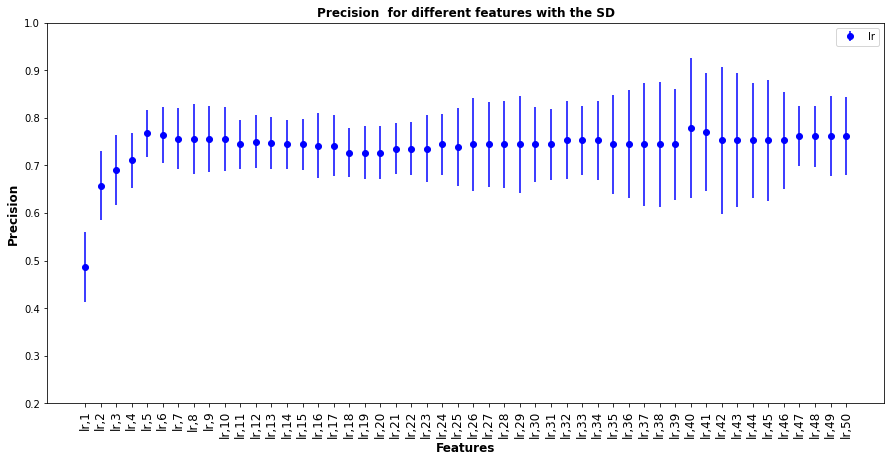

In [25]:
colors = ['blue', 'purple', 'green', 'orange', 'red', 'brown']
plt.figure(figsize=(15, 7))
plt.title( "Precision  for different features with the SD", fontweight ='bold', fontsize =12)
plt.xlabel("Features", fontweight ='bold', fontsize =12)
plt.ylabel("Precision", fontweight ='bold', fontsize =12)

count = 0
n = len(colors)-1

space = []
tickFeat = []

for result, model, color in zip(arr_all, models, colors):
    a = np.linspace(n*count, n*(1+count)-2,50)
    print(a)
    space.extend(a)
    tickFeat.extend(result[0])
    plt.errorbar( a, result[1], result[2], fmt='o', label =model[1], color = color)
    count += 1

plt.xticks(space, tickFeat, rotation = 'vertical',  fontsize =12)
plt.ylim(.2, 1)
plt.legend()

plt.show()

In [26]:
arr_diff_all = []

for m, m_key in zip (models, ml_dicts.keys()):
    acc_diff_arr = [] 
    sd_diff_arr = [] 
    for f_key in ml_dicts[m_key].keys():
        value = f_key.split(',')
        acc_diff_arr.append( ml_dicts[m_key][f_key][ 'tot_acc' ] - baseDict['lr']['lr, all'][ 'tot_acc' ]  )

        sd_train = jack_SD( baseDict['lr']['lr, all'][ 'jack_train' ], ml_dicts[m_key][f_key]['jack_train'] )[0]
        sd_test = jack_SD(  baseDict['lr']['lr, all'][ 'jack_test' ],  ml_dicts[m_key][f_key]['jack_test']   )[0]

        sd = np.sqrt( np.array((sd_train**2)) + np.array((sd_test**2)))
        sd_diff_arr.append(sd) # append sd_arr to an array
    arr_diff_all.append([ list(ml_dicts[m_key].keys()), acc_diff_arr, sd_diff_arr]) 

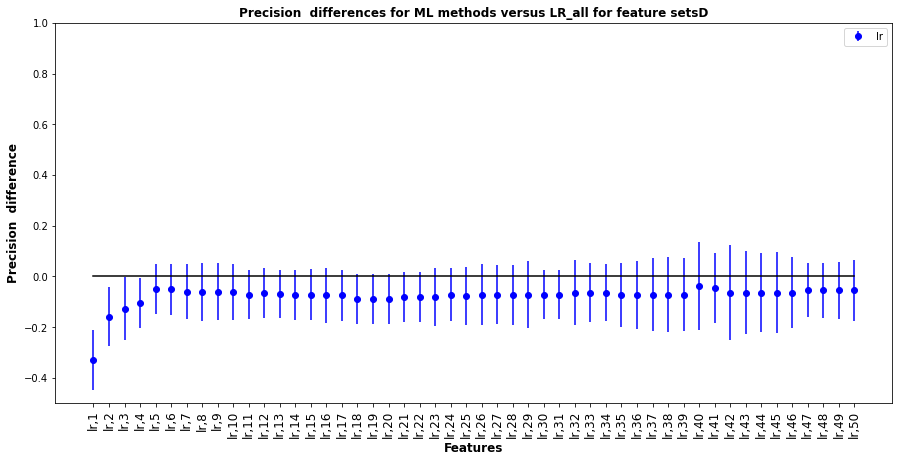

In [27]:
colors = ['blue', 'purple', 'green', 'orange', 'red', 'brown']
plt.figure(figsize=(15, 7))
plt.title( "Precision  differences for ML methods versus LR_all for feature setsD", fontweight ='bold', fontsize =12)
plt.xlabel("Features", fontweight ='bold', fontsize =12)
plt.ylabel("Precision  difference", fontweight ='bold', fontsize =12)

count = 0
n = len(colors)-0.5
space = []
tickFeat = []

for result, model, color in zip(arr_diff_all, models, colors):
    a = np.linspace(n*count, n*(1+count)-2,50)
    space.extend(a)
    tickFeat.extend(result[0])
    plt.errorbar( a, result[1], result[2], fmt='o', label =model[1], color = color)
    count += 1
    
plt.plot(np.array(space), np.zeros(50*1), color = 'Black')        
plt.xticks(space, tickFeat, rotation = 'vertical',  fontsize =12)
plt.ylim(-.5, 1)
plt.legend()

plt.show()